In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class PatchMatch:
    def __init__(self, target, source, patch_size=3, window_base_size=16, alpha=0.5):
        self.target = target
        self.source = source
        
        self.target_height, self.target_width = self.target.shape[:2]
        self.source_height, self.source_width = self.source.shape[:2]
        
        self.patch_size = patch_size
        self.margin = patch_size // 2
        self.window_base_size = window_base_size
        self.alpha = alpha
        self.random_search_window_sizes_num = (-np.log(window_base_size)/np.log(alpha)).astype(np.int32)
        self.random_search_window_half_sizes = [(window_base_size*np.power(alpha, i)).astype(np.int32) for i in range(self.random_search_window_sizes_num)]
        print("window search half-sizes: ", self.random_search_window_half_sizes)
        
        # paddings that extends values work worse for whatever reason
        self.target_padded = np.empty((self.target_height+2*self.margin, self.target_width+2*self.margin, self.target.shape[2]))
        self.target_padded[:] = np.nan
        self.target_padded[self.margin:-self.margin, self.margin:-self.margin] = self.target
        
        self.nnf = self.init_nearest_neighbor_field()
        self.dist = self.init_patch_distances()
    
    def patch_distance(self, target_patch_yx, source_patch_yx):
        t_y, t_x = target_patch_yx # left-top corner
        s_y, s_x = source_patch_yx # center
        target_patch = self.target_padded[t_y:t_y+self.patch_size, t_x:t_x+self.patch_size]
        source_patch = self.source[s_y-self.margin:s_y+self.margin+1, s_x-self.margin:s_x+self.margin+1]
        # mean instead of sum, as we have to skip nan's for partial match
        D = np.nanmean(np.square(target_patch - source_patch))
        return D
    
    def init_nearest_neighbor_field(self):
        y_init = np.random.randint(self.margin, self.source_height - self.margin, size=(self.target_height, self.target_width))
        x_init = np.random.randint(self.margin, self.source_width - self.margin, size=(self.target_height, self.target_width))
        nnf_init = np.stack((y_init, x_init), axis=2)
        return nnf_init
    
    def init_patch_distances(self):
        distances = np.zeros((self.target_height, self.target_width), dtype=np.float32)
        for h in range(self.target_height):
            for w in range(self.target_width):
                distances[h,w] = self.patch_distance((h, w), self.nnf[h,w])
        return distances
    
    def propagate(self, h, w, forward_scan):
        if forward_scan:
            h_candidate = max(0, h-1)
            w_candidate = max(0, w-1)
        else:
            h_candidate = min(self.target_height-1, h+1)
            w_candidate = min(self.target_width-1, w+1)
            
        D_base = self.dist[h,w]
        D_candidate_row = self.dist[h, w_candidate]
        D_candidate_col = self.dist[h_candidate, w]
        
        if D_candidate_row < D_base and D_candidate_row < D_candidate_col:
            self.nnf[h,w] = self.nnf[h,w_candidate]
            self.dist[h,w] = self.patch_distance((h,w), self.nnf[h,w_candidate])
        elif  D_candidate_col < D_base:
            self.nnf[h,w] = self.nnf[h_candidate,w]
            self.dist[h,w] = self.patch_distance((h,w), self.nnf[h_candidate,w])
        # else: no update
    
    def random_search(self, h, w):
        # seems like there is no major difference, whether jumps are consequent or from the same starting point
        # article apparently suggests later
        y_source, x_source = self.nnf[h, w]
        for window_size in self.random_search_window_half_sizes:
            # y_source, x_source = self.nnf[h, w]
            # clamp intervals of sampling to the  valid ones, so that we do not have to that later (that would skew distribution)
            y_min = max(self.margin, y_source - window_size // 2)
            y_max = min(self.source_height - self.margin, y_source + window_size // 2)
            x_min = max(self.margin, x_source - window_size // 2)
            x_max = min(self.source_width - self.margin, x_source + window_size // 2)

            y = np.random.randint(y_min, y_max)
            x = np.random.randint(x_min, x_max)
            
            D_base = self.dist[h, w]
            D_candidate = self.patch_distance((h, w), (y, x))          # calc dist
            if D_candidate < D_base:
                self.nnf[h, w] = np.array([y, x])
                self.dist[h, w] = D_candidate
    
    def iterate(self, iterations):
        for i in range(iterations):
            print("iteration:", i)
            if i%2 == 0:
                odd_iteration = True
                h_start, h_end = 0, self.target_height
                w_start, w_end = 0, self.target_width
                step = 1
            else: 
                odd_iteration = False
                h_start, h_end = self.target_height-1, -1
                w_start, w_end = self.target_width-1, -1
                step = -1
                
            for h in range(h_start, h_end, step):
                for w in range(w_start, w_end, step): 
                    self.propagate(h, w, odd_iteration)
                    self.random_search(h, w) 
    
    def display_nnf(self):
        nnf = np.concatenate((self.nnf, np.zeros((self.target_height, self.target_width, 1))), axis=2)
        nnf[..., 0] = nnf[..., 0]/nnf[..., 0].max()
        nnf[..., 1] = nnf[..., 1]/nnf[..., 1].max()
        plt.imshow(nnf)
        
    def display_target_through_source(self):
        y, x = self.nnf.reshape(-1,2).T
        target = self.source[y, x].reshape(self.target_height, self.target_width, -1)[..., ::-1]
        plt.imshow(target)

In [4]:
source = cv2.imread('frames/v001.jpg')
target = cv2.imread('frames/v010.jpg')
source = cv2.resize(source, (320, 180))
target = cv2.resize(target, (320, 180))

In [5]:
b = PatchMatch(target, source, 3, 128, 0.5)
b.iterate(5)

window search half-sizes:  [128, 64, 32, 16, 8, 4, 2]
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


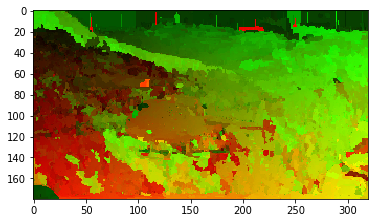

In [6]:
b.display_nnf()

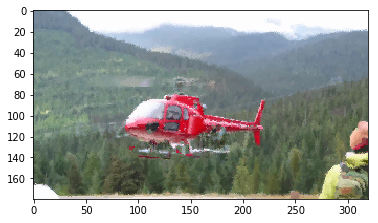

In [7]:
b.display_target_through_source()